In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
# Set a finite size of canvass
matplotlib.rcParams['figure.figsize'] = (10, 7)

# Generating a Dataset

Let's say start by generating we can play with. Fortunately, scikit-learn has some useful dataset generators, so we don't need to write the code ourselves. We will go with the `make_moons` functions.

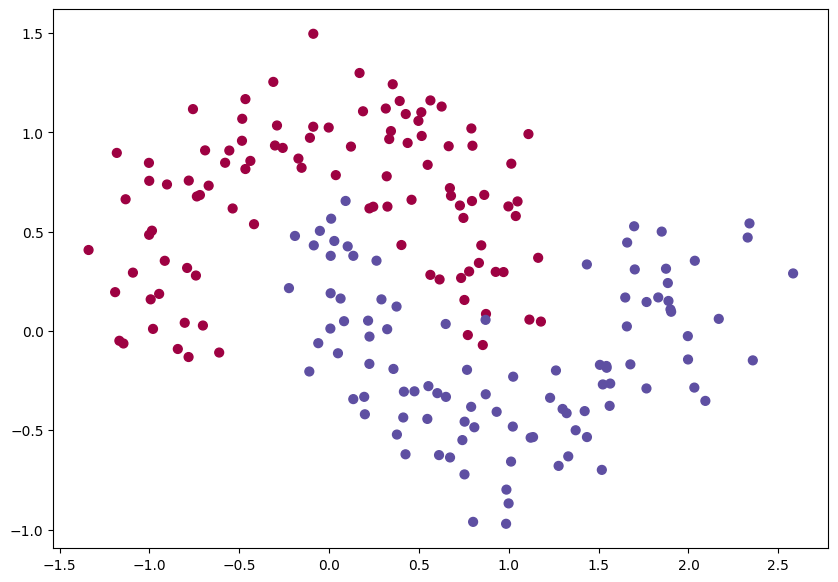

In [2]:
# Generate a dataset and plot it
np.random.seed(69)
X, y = sklearn.datasets.make_moons(200, noise = 0.20)
plt.scatter(X[:,0], X[:, 1], s = 40, c = y, cmap=plt.cm.Spectral)
plt.show()

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patiends and red dots as female patients, with x- and y- axis being medical measurements.

Our goal is to train a Machine Learning Classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not Linearly separable, we can't draw a straight line that separate the two classes. This means that linear classifiers, such as Logisitc Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

In fact, that's one of the major advantage of Neural Networks. You don't need to worry about feature engineering. The hidden layer of a neural network will learn features for you.

# Logistic Regression

To demonstrate the point let's train a Logistic Regression Classifier. It is input will be the x- and y- values and the output the predicted class (0 or 1). To make our life easy and comfortable we will use the Logistic Regression class from Scikit Learn library.

In [3]:
# Train the Logistic Regression Classifier Model
lr_clf = sklearn.linear_model.LogisticRegressionCV()
lr_clf.fit(X, y)

LogisticRegressionCV()

In [34]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

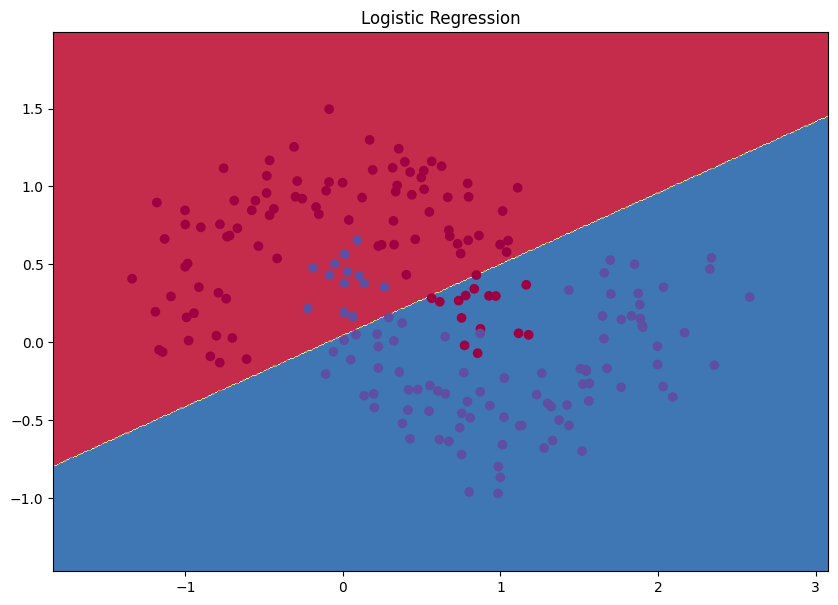

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: lr_clf.predict(x))
plt.title("Logistic Regression")
plt.show()

The graph shows the decision boundary learned by our Logistic Regression classifier model. It separates the data as good as it can using a straight line, but it's unable to capture the `moon shape` of our data.

Something like this, for red dot.

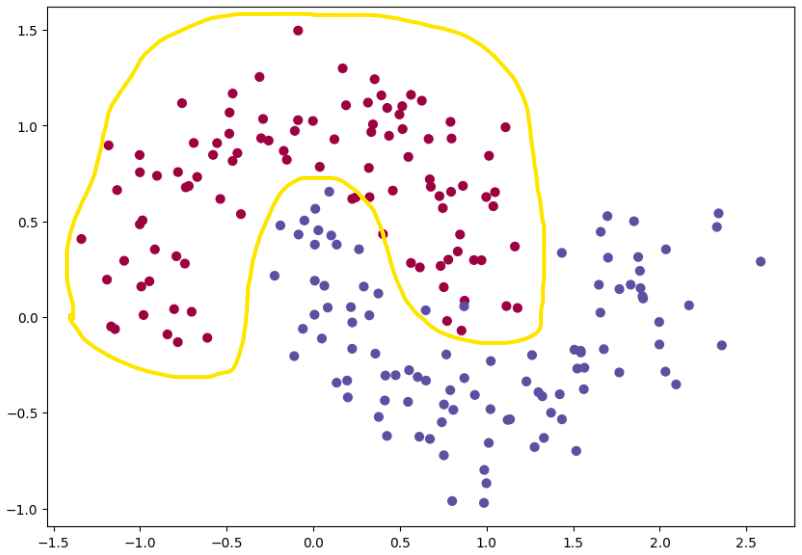

# Training a Neural Network

Let's now build a 2-layer neural network. The number of nodes in the input layer is determined by the dimensionality of our data.

In [6]:
num_examples = len(X) # also called 'm'
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization rate

In [7]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate loss
    z1 = np.dot(X, W1) + b1 # LR linear activation
    A1 = np.tanh(z1) # tanh activation function
    ZL = np.dot(A1, W2) + b2
    AL = np.exp(ZL)
    probs = AL / np.sum(AL, axis = 1, keepdims=True)

    # Calculating the loss
    loss_func = -np.log(probs[range(num_examples), y])
    cost_func = np.sum(loss_func)

    # Initialize regularization loss
    reg_loss = 0.0
    
    # Add regularization term to loss(optional)
    reg_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))

    # Compute the total loss
    total_loss = cost_func + reg_loss
    return 1.0/num_examples * total_loss

Finally, here comes the function to train our NN. It implements batch gradient descent using the back propagation derivatives.

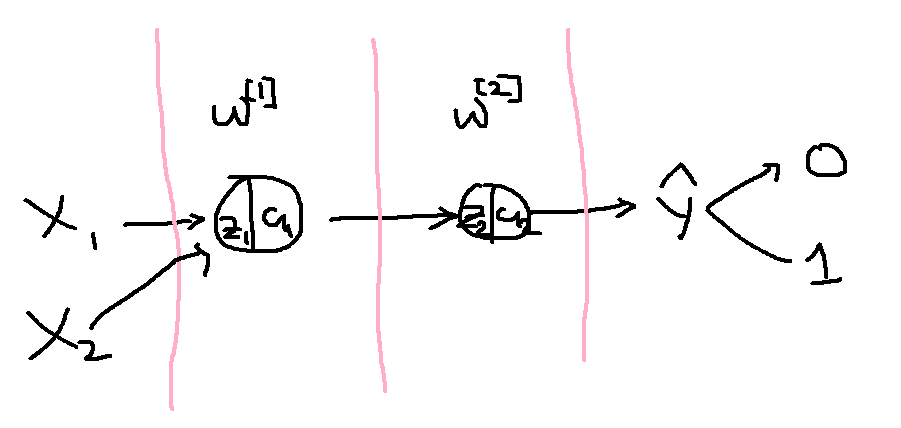

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If true, print the loss every 1000 iterations

def build_model(nn_hdim, num_passess = 20000, print_loss= False):

    # Define the nn_input_dim and nn_output_dim based on the data
    nn_input_dim = 2
    nn_output_dim = 2 # number of output classes

    # Initialize the weight matrices and bias vectors. 
    np.random.seed(69)
    W1 = np.random.randn(nn_input_dim, nn_hdim)/ np.sqrt(nn_input_dim)
    b1 = np.zeros(shape = (1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim)/ np.sqrt(nn_hdim)
    b2 = np.zeros(shape = (1, nn_output_dim))

    model = {}

    # We compute the gradient descent during the iteration of below loop
    for i in range (0, num_passess):

        # Forward propagation
        Z1 = np.dot(X, W1) + b1
        A1 = np.tanh(Z1)
        ZL = np.dot(A1, W2) + b2
        AL = np.exp(ZL)
        probs = AL/np.sum(AL, axis = 1, keepdims = True)

        # Back propagation
        dev_probs_2 = probs
        dev_probs_2[range(num_examples), y] -=1
        dW2 = np.dot(A1.T, dev_probs_2)
        db2 = np.sum(dev_probs_2, axis = 0, keepdims = True)
        dev_probs_1 = np.dot(dev_probs_2, W2.T) * (1-np.power(A1, 2))
        dW1 = np.dot(X.T, dev_probs_1)
        db1 = np.sum(dev_probs_1, axis = 0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient Descent Parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # Assign new parameters to the model
        model = {'W1': W1,
                 'b1': b1,
                 'W2': W2,
                 'b2': b2}
        
        
        # Optional to print the loss.
        # This is quite long to train because it uses the whole dataset, we don't want to do it often
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    return model

In [41]:
# Train the model by fitting the data with 5 hidden layers
model = build_model(5, print_loss=True)

Loss after iteration 0: 0.455404
Loss after iteration 1000: 0.036813
Loss after iteration 2000: 0.035317
Loss after iteration 3000: 0.034635
Loss after iteration 4000: 0.034218
Loss after iteration 5000: 0.033926
Loss after iteration 6000: 0.033714
Loss after iteration 7000: 0.033556
Loss after iteration 8000: 0.033436
Loss after iteration 9000: 0.033343
Loss after iteration 10000: 0.033270
Loss after iteration 11000: 0.033212
Loss after iteration 12000: 0.033166
Loss after iteration 13000: 0.033129
Loss after iteration 14000: 0.033099
Loss after iteration 15000: 0.033074
Loss after iteration 16000: 0.033054
Loss after iteration 17000: 0.033038
Loss after iteration 18000: 0.033025
Loss after iteration 19000: 0.033014


In [42]:
# Helper function to make a prediction
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate or make predictions
    Z1 = np.dot(x, W1) + b1
    A1 = np.tanh(Z1)
    ZL = np.dot(A1, W2) + b2
    AL = np.exp(ZL)
    probs = AL/ np.sum(AL, axis = 1, keepdims = True)
    return np.argmax(probs, axis = 1)

In [43]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Contour plot of the decision boundary
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    
    # Plot the training data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title('Decision Boundary')
    plt.show()

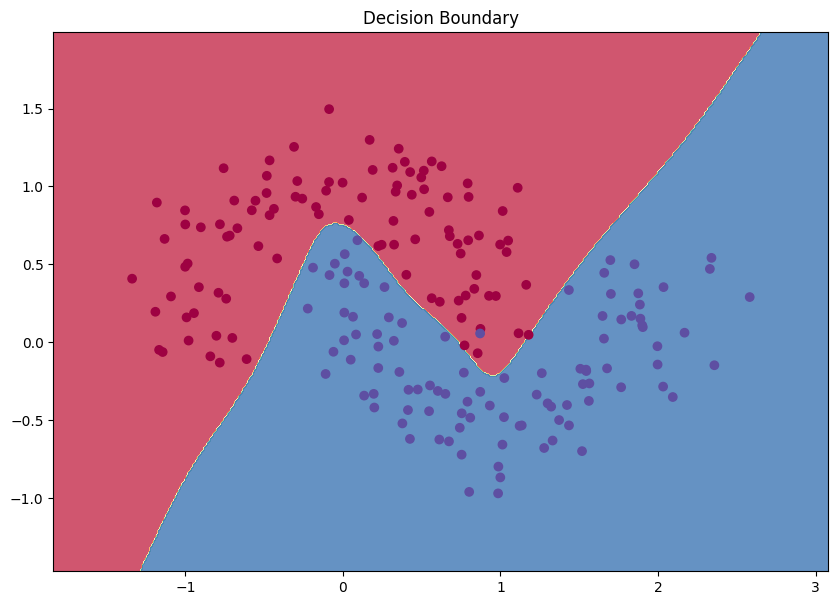

In [44]:
plot_decision_boundary(lambda x: predict(model = model, x =x))

The image displays a noticeable grouping of red and blue data points. While the majority exhibit clear clustering, a few outliers are visible. Furthermore, the intensity of red and blue shades is relatively subdued. This suggests that the model might still possess uncertainty in its predictions.

# Changing the Hidden Layer Size

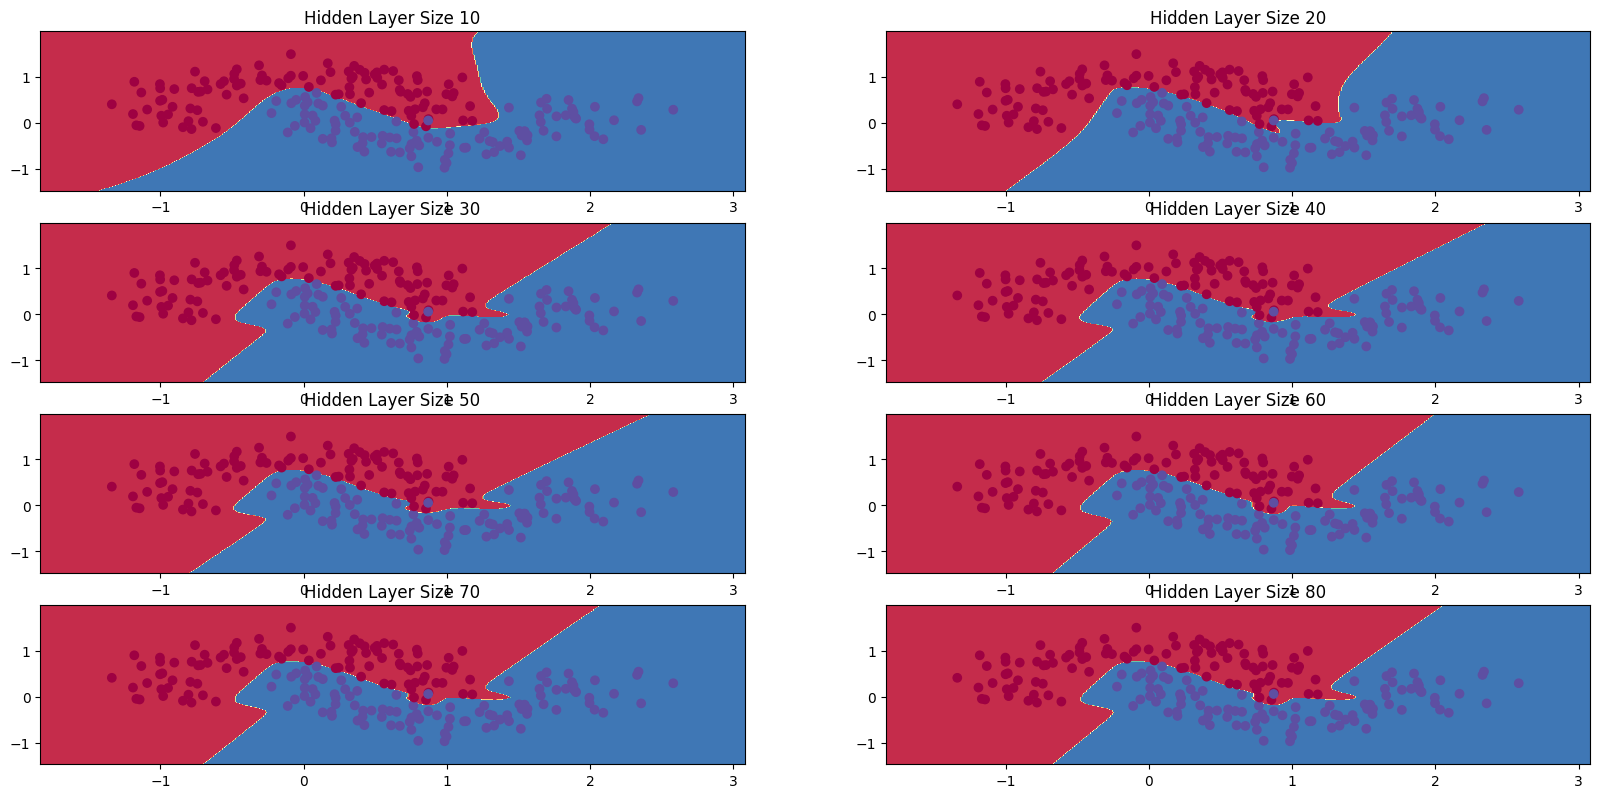

In [40]:
hidden_layer_dim = [10, 20, 30, 40, 50, 60, 70, 80]
plt.figure(figsize=(20,12))
for i, nn_hdim in enumerate(hidden_layer_dim):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer Size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model = model, x = x))
plt.show()


Here, we can see a change of the color intensity which also indicate that the model as gained a more certainty in its predictions.